# Setting up

In [71]:
!pip install -qq sentencepiece
!pip install -qq transformers==4.7.0
!pip install -qq unidecode

In [72]:
!gdown --id -qq 1up7d8aWd0H-QDN2konB_4oAwa4oHJQr2
!gdown --id -qq 141nsJ-dt-ZDR0aM1GkY2CGEmKeIM7O1F 
!gdown --id 1mUoiYzyUs6ihlmkqskdPPgo0O1ainWqw
!unzip -qq wassa_dataset.zip
!rm wassa_dataset.zip

Downloading...
From: https://drive.google.com/uc?id=1mUoiYzyUs6ihlmkqskdPPgo0O1ainWqw
To: /content/codes.json
100% 216k/216k [00:00<00:00, 112MB/s]
replace wassa_train.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
replace wassa_test.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
replace wassa_val.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y


In [73]:
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch
import torch.utils
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder
import pickle
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import itertools
from nltk.tokenize import TweetTokenizer
from sklearn.metrics import accuracy_score
import re
import unidecode
from nltk import PorterStemmer, word_tokenize
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report
from transformers import MT5Tokenizer
from transformers import RobertaTokenizer, RobertaModel, BertTokenizer, BertModel, AlbertModel, AlbertTokenizer, AutoModel, AutoTokenizer

In [74]:
nltk.download("all") 

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Package alpino is already up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger is already up-
[nltk_data]    |       to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger_ru is already
[nltk_data]    |       up-to-date!
[nltk_data]    | Downloading package basque_grammars to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package basque_grammars is already up-to-date!
[nltk_data]    | Downloading package biocreative_ppi to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Pac

True

# Loading the dataset

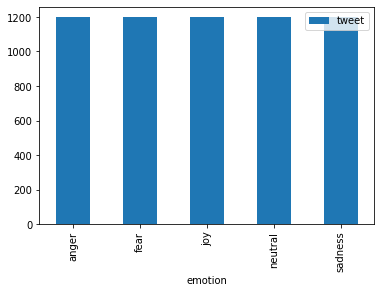

         tweet
emotion       
anger     1200
fear      1200
joy       1200
neutral   1200
sadness   1200


In [75]:
df_train = pd.read_csv("wassa_train.csv")
df_val = pd.read_csv("wassa_val.csv")
df_test = pd.read_csv("wassa_test.csv")

n_samples = df_train[["tweet", "emotion"]].groupby("emotion").count()
n_samples.plot(kind="bar")
plt.show()

print(n_samples)

In [76]:
emotions_list=["joy", "anger", "fear", "sadness", "neutral"]

In [77]:
texts_train = df_train.tweet.tolist()
texts_val = df_val.tweet.tolist()
texts_test = df_test.tweet.tolist()

label_encoder = LabelEncoder()
emotions_train = label_encoder.fit_transform(df_train.emotion.tolist())
emotions_val = label_encoder.transform(df_val.emotion.tolist())
emotions_test = label_encoder.transform(df_test.emotion.tolist())

#Preprocessing the dataset

In [78]:
def preprocess_text(text_list):
  for i, text in enumerate(text_list):
    # eliminate URLs
    result = re.result = re.sub(r"http\S+", "", text)
    # eliminate email addresses
    result = re.sub('\S*@\S*\s?', '', result)
    text_list[i] = result

In [79]:
preprocess_text(texts_train)
preprocess_text(texts_val)
preprocess_text(texts_test)

# Useful functions

In [80]:
def pickle_object(object, location):
    filehandler = open(location, "wb")
    pickle.dump(object, filehandler)
    filehandler.close()

def pickle_load_object(location):
    file = open(location, 'rb')
    object = pickle.load(file)
    file.close()
    return object

def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.rcParams.update({'font.size': 20})
    plt.figure(figsize=(12, 8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

def compute_metrics(y_true, predictions):
  average = "macro"
  acc = accuracy_score(y_true, predictions)
  precision = precision_score(y_true, predictions, average=average)
  recall = recall_score(y_true, predictions, average=average)
  f1 = f1_score(y_true, predictions, average=average)
  print(f"Model has acc = {acc}\n, precision = {precision}\n, recall = {recall}\n, f1_score = {f1}\n")




# Model and tokenizer selection functions





In [81]:
def get_model(model_name):
  model = None
  if model_name == 'bert-base-cased':
      model = BertModel.from_pretrained(model_name)

  if model_name == 'roberta-base':
      model = RobertaModel.from_pretrained(model_name)
 
  if model_name == 'vinai/bertweet-base':
      model = AutoModel.from_pretrained(model_name)

  return model

def get_tokenizer(model_name):
    tokenizer = None
    if model_name == 'bert-base-cased':
      tokenizer = BertTokenizer.from_pretrained(model_name)

    if model_name == 'roberta-base':
      tokenizer = RobertaTokenizer.from_pretrained(model_name)

    if model_name == 'vinai/bertweet-base':
      tokenizer = AutoTokenizer.from_pretrained(model_name, normalization=True, use_fast=False)
    
    return tokenizer

# Choosing the device and model

In [82]:
# this colab supports training for bert-base-cased roberta-base vinai/bertweet-base models
PRE_TRAINED_MODEL_NAME = 'vinai/bertweet-base'
tokenizer = get_tokenizer(PRE_TRAINED_MODEL_NAME)
if tokenizer is None:
  print("Wrong model! Choose another one.")

emoji is not installed, thus not converting emoticons or emojis into text. Please install emoji: pip3 install emoji
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [83]:
epoch_dict = {"bert-base-cased" : 5, "roberta-base":5, "vinai/bertweet-base":5}
maxlen_dict = {"bert-base-cased" : 85, "roberta-base":170, "vinai/bertweet-base":90}

In [84]:
EPOCHS = epoch_dict[PRE_TRAINED_MODEL_NAME]
BATCH_SIZE = 16 # higher batch size might aid in the latter stages of fine tuning
maxlen = maxlen_dict[PRE_TRAINED_MODEL_NAME]
device = "cuda" if torch.cuda.is_available() else "cpu"

device

'cuda'

# Building the PyTorch datasets and dataloaders

In [85]:
class WassaDataset(Dataset):

  def __init__(self, texts, emotions, tokenizer, max_len):
    self.texts = texts
    self.emotions = emotions
    self.tokenizer = tokenizer
    self.max_len = max_len

  def __len__(self):
    return len(self.texts)

  def __getitem__(self, item):
    text = str(self.texts[item])
    emotion = self.emotions[item]
    encoding = self.tokenizer.encode_plus(
      text,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      padding='max_length',
      return_attention_mask=True,
      return_tensors='pt',
    )

    return {
      'text': text,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'emotions': torch.tensor(emotion, dtype=torch.long)
    }

In [86]:
def create_data_loader(texts, emotions, tokenizer, max_len, batch_size):
  dataset = WassaDataset(
    texts=texts,
    emotions=emotions,
    tokenizer=tokenizer,
    max_len=max_len)

  return DataLoader(
    dataset,
    batch_size=batch_size,
    num_workers=2
  )

In [87]:
train_data_loader = create_data_loader(texts_train, emotions_train, tokenizer, maxlen, BATCH_SIZE)
val_data_loader = create_data_loader(texts_val, emotions_val, tokenizer, maxlen, BATCH_SIZE)
test_data_loader = create_data_loader(texts_test, emotions_test, tokenizer, maxlen, BATCH_SIZE)

# Building the model

In [88]:
class EmotionsClassifier(nn.Module):
  def __init__(self, n_classes, model_name):
    super(EmotionsClassifier, self).__init__()
    self.bert = get_model(model_name)
    self.drop = nn.Dropout(p=0.3)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
    self.softmax = nn.LogSoftmax(dim=1)

  def forward(self, input_ids, attention_mask):
    _, pooled_output = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask,
      return_dict=False
    )
    output = self.drop(pooled_output)
    output = self.out(output)
    return self.softmax(output)

In [89]:
model = EmotionsClassifier(len(emotions_list), PRE_TRAINED_MODEL_NAME)
model.to(device)

Some weights of the model checkpoint at vinai/bertweet-base were not used when initializing RobertaModel: ['lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.bias', 'lm_head.decoder.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


EmotionsClassifier(
  (bert): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(64001, 768, padding_idx=1)
      (position_embeddings): Embedding(130, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0): RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((

In [90]:
optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = nn.NLLLoss().to(device)

# Training and validation

In [91]:
def train_epoch(model, data_loader, loss_fn, optimizer, device, scheduler, n_examples):
  model = model.train()
  losses = []
  correct_predictions = 0
  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    emotions = d["emotions"].to(device)
    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )
    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, emotions)
    correct_predictions += torch.sum(preds == emotions)
    losses.append(loss.item())
    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

  return correct_predictions.double() / n_examples, np.mean(losses)

In [92]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()
  losses = []
  correct_predictions = 0
  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      emotions = d["emotions"].to(device)
      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)
      loss = loss_fn(outputs, emotions)
      correct_predictions += torch.sum(preds == emotions)
      losses.append(loss.item())

  return correct_predictions.double() / n_examples, np.mean(losses)

In [93]:
%%time

history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):
  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)
  train_acc, train_loss = train_epoch(
    model,
    train_data_loader,
    loss_fn,
    optimizer,
    device,
    scheduler,
    len(texts_train)
  )

  print(f'Training loss {train_loss} accuracy {train_acc}')

  val_acc, val_loss = eval_model(
    model,
    val_data_loader,
    loss_fn,
    device,
    len(texts_val)
  )

  print(f'Validation loss {val_loss} accuracy {val_acc}')
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'best_model_state.bin')
    best_accuracy = val_acc

Epoch 1/5
----------
Training loss 0.7209226200083891 accuracy 0.7406666666666667
Validation loss 0.4706594865927671 accuracy 0.8653333333333333

Epoch 2/5
----------
Training loss 0.3062632912099361 accuracy 0.9086666666666666
Validation loss 0.4205921998326766 accuracy 0.8826666666666666

Epoch 3/5
----------
Training loss 0.18332345979164044 accuracy 0.9478333333333333
Validation loss 0.43096471312356754 accuracy 0.896

Epoch 4/5
----------
Training loss 0.10823735368375977 accuracy 0.9718333333333333
Validation loss 0.45704999788010375 accuracy 0.892

Epoch 5/5
----------
Training loss 0.07515619136641423 accuracy 0.9816666666666667
Validation loss 0.48379290330798386 accuracy 0.892

CPU times: user 6min 36s, sys: 2min 47s, total: 9min 24s
Wall time: 9min 30s
Parser   : 110 ms


# Plotting training history

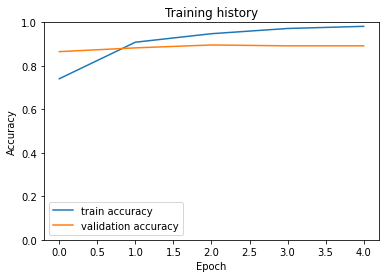

In [94]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

# BERT_model Class





In [95]:
class Bert_model:
  def __init__(self, model, encoder, tokenizer, maxlen):
    self._model = model
    self._encoder = encoder
    self._tokenizer = tokenizer
    self._device = "cpu"
    self._maxlen = maxlen

  def set_device(self, device):
    self._device = device
    self._model.to(device)

  def _preprocess_text(self, text):
      # eliminate URLs
      result = re.result = re.sub(r"http\S+", "", text)
      # eliminate email addresses
      result = re.sub('\S*@\S*\s?', '', result)
      return result

  def _make_prediction_for_text(self, text):
    text = self._preprocess_text(text)
    encoding = self._tokenizer.encode_plus( 
        text,
        add_special_tokens=True,
        max_length=self._maxlen,
        return_token_type_ids=False,
        padding='max_length',
        return_attention_mask=True,
        return_tensors='pt'
    )
    
    input_ids = encoding['input_ids'].to(self._device)
    attention_mask = encoding['attention_mask'].to(self._device)
    outputs = self._model(
        input_ids=input_ids,
        attention_mask=attention_mask
    )
    outputs.to(self._device)
    return outputs.cpu().detach().numpy()

  def detect_emotions_with_labels(self, texts):
    predicted_emotions = []
    for text in texts:
      emotion = self._make_prediction_for_text(text)
      pred = np.argmax(emotion, axis=1)
      prediction = self._encoder.inverse_transform(pred)
      predicted_emotions.append(prediction[0])
    return predicted_emotions
  
  def detect_emotions_with_proba(self, texts):
    predicted_emotions = []
    for text in texts:
      emotion_proba = self._make_prediction_for_text(text)
      predicted_emotions.append(emotion_proba)
    return np.concatenate(predicted_emotions)

In [96]:
bert_model = Bert_model(model, label_encoder, tokenizer, maxlen)

In [97]:
bert_model.set_device("cuda")

## Bert model validation

In [98]:
bert_predictions = bert_model.detect_emotions_with_labels(texts_val)
y_true = label_encoder.inverse_transform(emotions_val)
compute_metrics(y_true, bert_predictions)

Model has acc = 0.892
, precision = 0.8956290971675586
, recall = 0.8920000000000001
, f1_score = 0.892901745292917



## Bert model testing

In [99]:
bert_predictions = bert_model.detect_emotions_with_labels(texts_test)
y_true = label_encoder.inverse_transform(emotions_test)
compute_metrics(y_true, bert_predictions)

Model has acc = 0.8853333333333333
, precision = 0.8863109261059087
, recall = 0.8853333333333333
, f1_score = 0.8856236741919812



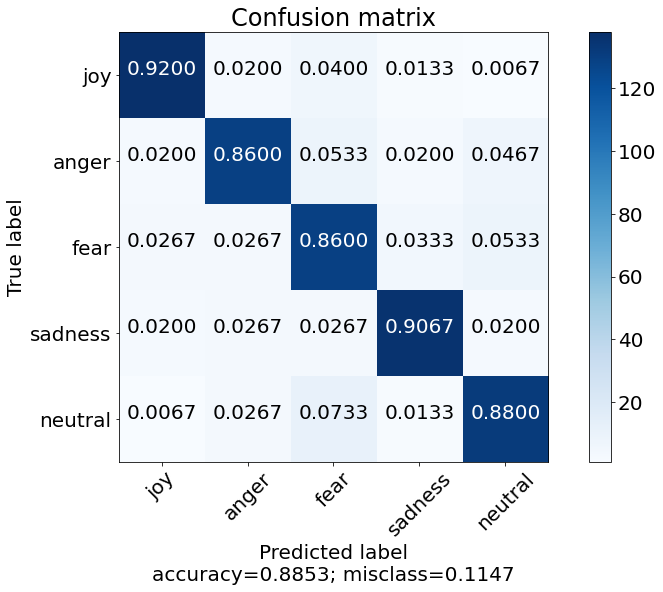

In [100]:
cm = confusion_matrix(y_true, bert_predictions, labels=emotions_list)
plot_confusion_matrix(cm, emotions_list)

In [101]:
print(classification_report(y_true, bert_predictions))

              precision    recall  f1-score   support

       anger       0.90      0.86      0.88       150
        fear       0.82      0.86      0.84       150
         joy       0.93      0.92      0.92       150
     neutral       0.87      0.88      0.88       150
     sadness       0.92      0.91      0.91       150

    accuracy                           0.89       750
   macro avg       0.89      0.89      0.89       750
weighted avg       0.89      0.89      0.89       750



# Building the ensemble model

## Adding the SVM model to the ensemble model

In [105]:
class SVM_model:
  def __init__(self, classifier, encoder, stop_words, vectorizer):
    self._classifier = classifier
    self._encoder = encoder
    self._stop_words = stop_words
    self._vectorizer = vectorizer
  
  def _preprocess_text(self, text, stop_words):
    # make lowercase and strip empty spaces
    result = text.lower()
    # strip extra spaces
    result = result.strip()
    # eliminate URLs
    result = re.result = re.sub(r"http\S+", "", result)
    # eliminate email addresses
    result = re.sub('\S*@\S*\s?', '', result)
    # strip diacritics
    result = unidecode.unidecode(result)
    # english stopwords
    word_list = word_tokenize(result)
    # english stemmer
    ps = SnowballStemmer("english")
    stemmed_sentence = ""
    for word in word_list:
        if word not in stop_words:
            stemmed_sentence += ps.stem(word)
            stemmed_sentence += " "
    result = stemmed_sentence
    whitelist = set('abcdefghijklmnopqrstuvwxyz ABCDEFGHIJKLMNOPQRSTUVWXYZ')
    result = ''.join(filter(whitelist.__contains__, result))
    result = ''.join([i for i in result if not i.isdigit()])
    return result

  def _vectorize_texts(self, texts):
    vectorized_texts = []
    for text in texts:
      processed_text = self._preprocess_text(text, self._stop_words)
      vectorized_texts.append(processed_text)
    return self._vectorizer.transform(vectorized_texts)

  def detect_emotions_with_labels(self, texts):
    vectorized_texts = self._vectorize_texts(texts)
    predictions = self._classifier.predict_log_proba(vectorized_texts)
    predictions  = list(self._encoder.inverse_transform(np.argmax(predictions, axis=1)))
    return predictions

  def detect_emotions_with_proba(self, texts):
    vectorized_texts = self._vectorize_texts(texts)
    predictions = self._classifier.predict_log_proba(vectorized_texts)
    return predictions

  def proba_to_labels(self, proba):
      labels  = list(self._encoder.inverse_transform(np.argmax(proba, axis=1)))
      return labels

In [106]:
svm_model = pickle_load_object("svm_model.obj")

## Ensemble model testing

In [107]:
bert_predictions = bert_model.detect_emotions_with_proba(texts_test)
svm_predictions = svm_model.detect_emotions_with_proba(texts_test)
# combine results for the ensemble model
predictions = svm_predictions+bert_predictions 

In [108]:
y_true = label_encoder.inverse_transform(emotions_test)

In [109]:
# get labels from ensemble model
predicted_emotions_inv = svm_model.proba_to_labels(predictions)

In [110]:
acc = accuracy_score(y_true, predicted_emotions_inv)
acc

0.9146666666666666

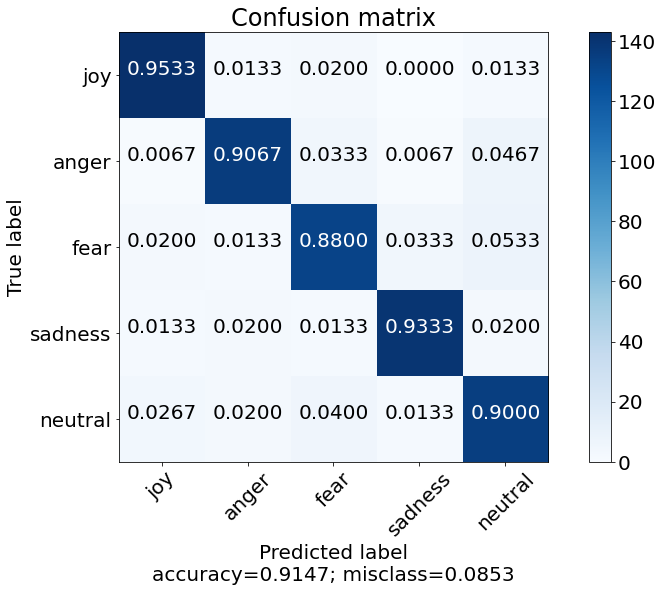

In [111]:
cm = confusion_matrix(y_true, predicted_emotions_inv, labels=emotions_list)
plot_confusion_matrix(cm, emotions_list)

In [112]:
print(classification_report(y_true, predicted_emotions_inv))

              precision    recall  f1-score   support

       anger       0.93      0.91      0.92       150
        fear       0.89      0.88      0.89       150
         joy       0.93      0.95      0.94       150
     neutral       0.87      0.90      0.89       150
     sadness       0.95      0.93      0.94       150

    accuracy                           0.91       750
   macro avg       0.91      0.91      0.91       750
weighted avg       0.91      0.91      0.91       750



## Ensemble model class

In [113]:
class Ensemble_Model:
  def __init__(self, bert_model, svm_model):
    self._bert_model = bert_model
    self._svm_model = svm_model
  
  def set_bert_device(self, device):
    self._bert_model.set_device(device)

  def detect_emotions(self, texts):
    svm_predictions = self._svm_model.detect_emotions_with_proba(texts)
    bert_predictions = self._bert_model.detect_emotions_with_proba(texts)
    predictions = svm_predictions+bert_predictions
    return self._svm_model.proba_to_labels(predictions)


##  Ensemble model validation

In [114]:
en_model = Ensemble_Model(bert_model, svm_model)

In [115]:
en_model.set_bert_device("cpu")

In [116]:
predictions = en_model.detect_emotions(texts_test)

In [117]:
acc = accuracy_score(df_test.emotion.tolist(), predictions)
acc

0.9146666666666666

In [119]:
pickle_object(en_model, "english_model.obj")

In [120]:
predictions = en_model.detect_emotions(["I am sitting home", "New York is a big city", "The president has arrived"])
predictions

['neutral', 'neutral', 'fear']